
# Mount GDrive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# change working directory

In [ ]:
!ls -la
%cd /content/drive/My\ Drive/MedVer_test
!ls
!pwd


total 20
drwxr-xr-x 1 root root 4096 Jul 16 08:03 .
drwxr-xr-x 1 root root 4096 Jul 16 08:02 ..
drwxr-xr-x 4 root root 4096 Jul  1 13:41 .config
drwx------ 5 root root 4096 Jul 16 08:03 drive
drwxr-xr-x 1 root root 4096 Jul  1 13:42 sample_data
/content/drive/My Drive/MedVer_test
 cnn3_autoenc.h5
 cnn3_autoenc_weights.h5
'Copy of Real and AI-Generated Faces classification.gdoc'
 dataset1
 dataset1.zip
 dataset2
 dataset2.zip
 model_arch_autoen.json
 model.png
/content/drive/My Drive/MedVer_test


# Import

In [ ]:

from tensorflow.keras import layers,utils,optimizers
from tensorflow.keras.models import Sequential,Model,load_model,model_from_json
from PIL import Image 
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.metrics import confusion_matrix
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
# Assure Reproducibility
from tensorflow import random
np.random.seed(1337)
random.set_seed(1337)



# **`Read unlabeled dataset images `**




In [ ]:
def image_gen(imgs_paths):
    # Iterate over all the image paths
    for image_file in imgs_paths: 
        #img = np.array(Image.open(os.path.join(folder,filename)) 
       
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(image_file) / 255.
                      
        # Yield the image mask pair
        yield img

def image_batch_generator(imgs_paths, batchsize=32):
    while True:
        ig = image_gen(imgs_paths)
        batch_img = []
        
        for img in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
           
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0),np.stack(batch_img, axis=0)
                batch_img= []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_img, axis=0)
            batch_img= []

# **Create an AutoEncoder Model -- PART A**

(None, 32, 32, 64)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_34 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
activation_34 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_35 (Activation)   (None

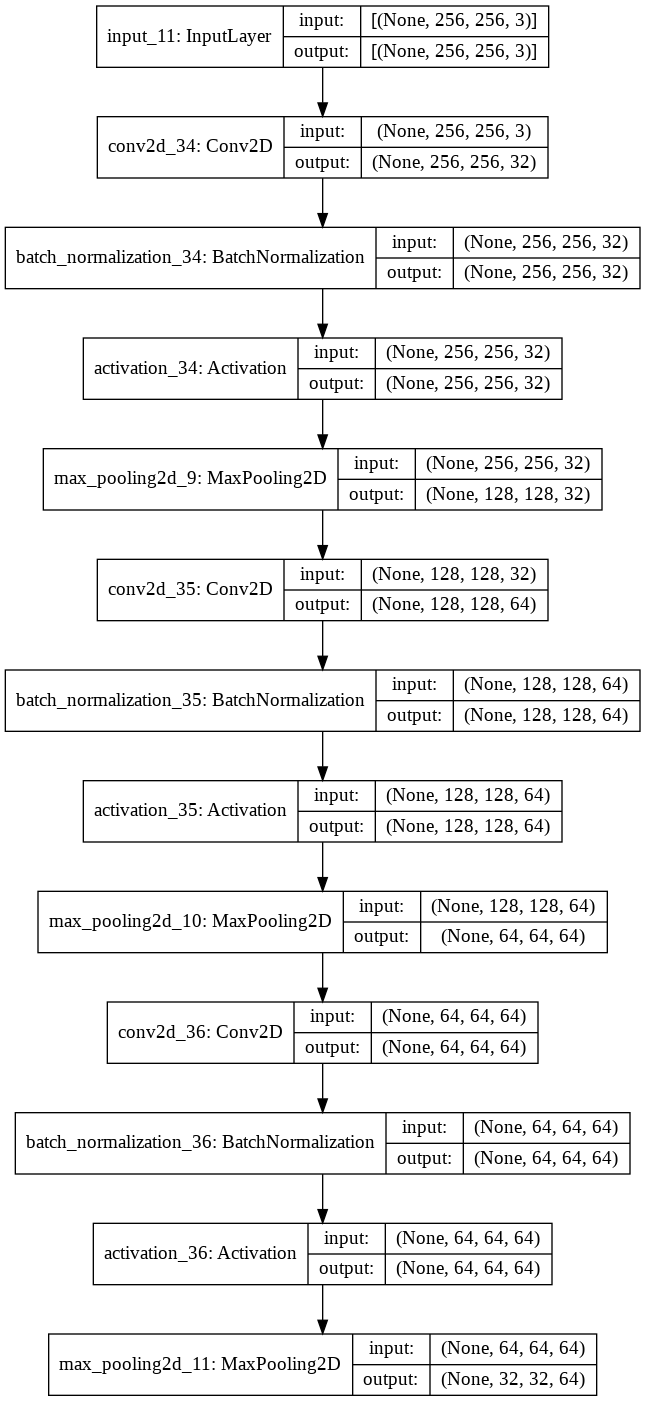

In [ ]:
input_shape = [256,256,3] # take a shape of image (256,256,3)
model_encoder = Sequential(
    [
        layers.InputLayer(input_shape),  
        
       
        layers.Conv2D(filters=32, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Activation('relu'),
 
        layers.MaxPooling2D(pool_size=2,strides=2),
 
        layers.Conv2D(filters=64, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
 
        layers.Activation('relu'),
 
        layers.MaxPooling2D(pool_size=2,strides=2),
 
 
        layers.Conv2D(filters=64, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
 
        layers.Activation('relu'),
 
        layers.MaxPooling2D(pool_size=2,strides=2),
     
       

      
        
     
 
    ]
)
encoder_outshape = model_encoder.layers[-1].output_shape # get last layer output shape
print(encoder_outshape)
model_encoder.summary()
utils.plot_model(model_encoder, show_shapes=True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_38 (Activation)   (None, 64, 64, 32)      

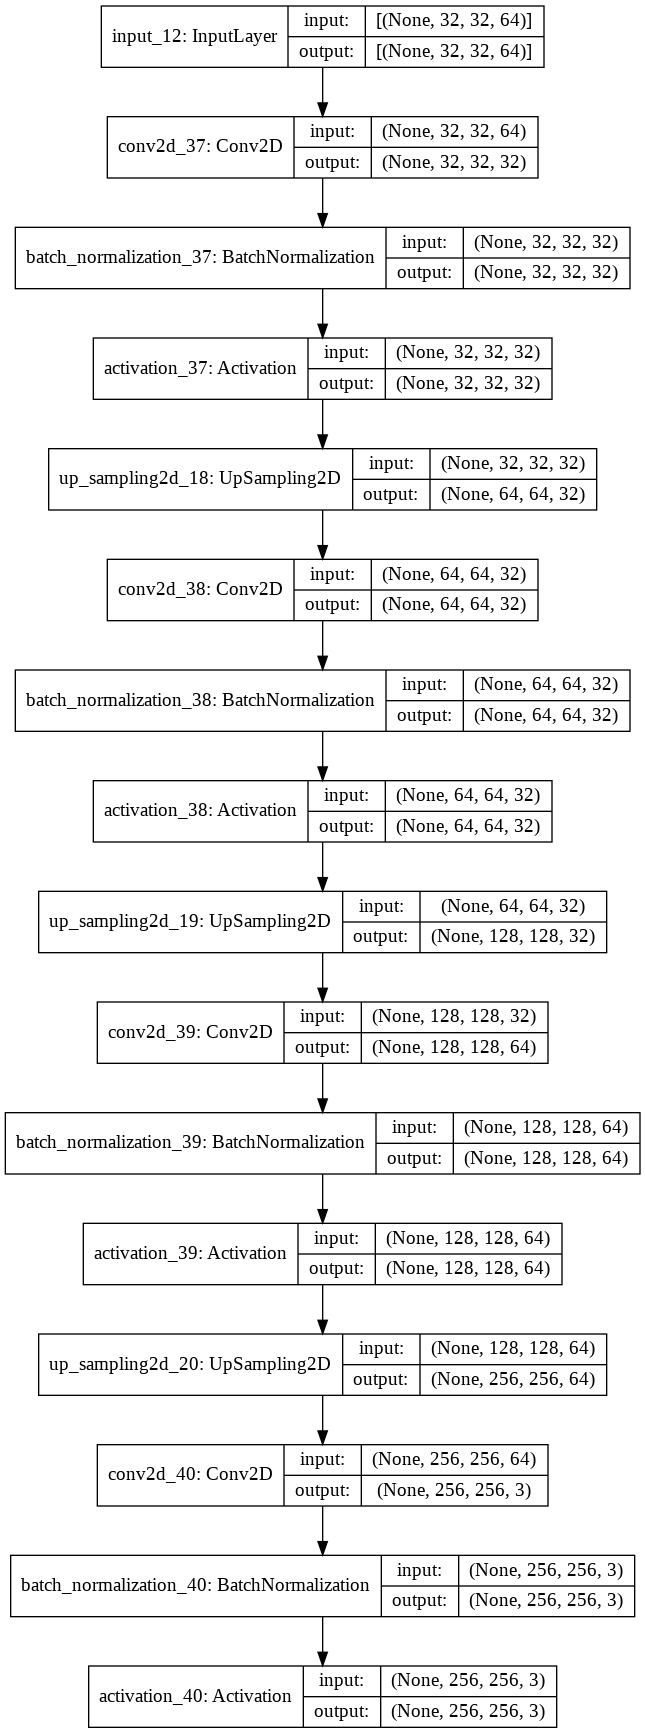

In [ ]:
model_decoder = Sequential(
    [
         
        layers.InputLayer(encoder_outshape[1:]),

        
     
        layers.Conv2D(filters=32, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.UpSampling2D((2,2)),
        
        layers.Conv2D(filters=32, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),        
        layers.Activation('relu'),
        
        layers.UpSampling2D((2,2)),
     
        layers.Conv2D(filters=64, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),        
        layers.Activation('relu'),
        
        layers.UpSampling2D((2,2)),

       
     
      
     
        layers.Conv2D(filters=3, kernel_size=3,  padding='same'),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),
        
        
 
    ]
)
model_decoder.summary()
utils.plot_model(model_decoder, show_shapes=True)

# **Train Proccess for the Autoencoder**

In [ ]:

BATCHSIZE = 64
folder = 'dataset1'
train_img_paths = [os.path.join(folder,filename)for filename in os.listdir(folder)]
print(train_img_paths[:10])

# # Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.2,shuffle=True)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

stacked_autoencoder = Sequential([model_encoder, model_decoder])
# Compile the stacked model and train with adam
stacked_autoencoder.compile(loss="mse",
                   optimizer='adam',metrics=["accuracy"])
# Train the model
history = stacked_autoencoder.fit(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs=20, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=10 # Change this number based on memory restrictions
)





['dataset1/34700.jpg', 'dataset1/30064.jpg', 'dataset1/02046.jpg', 'dataset1/09723.jpg', 'dataset1/53911.jpg', 'dataset1/54424.jpg', 'dataset1/43176.jpg', 'dataset1/46873.jpg', 'dataset1/46942.jpg', 'dataset1/69695.jpg']
Epoch 1/20
125/125 [==============================] - 56s 439ms/step - loss: 0.0142 - accuracy: 0.6622 - val_loss: 0.0407 - val_accuracy: 0.7829
Epoch 2/20
125/125 [==============================] - 54s 435ms/step - loss: 0.0074 - accuracy: 0.7548 - val_loss: 0.0225 - val_accuracy: 0.8024
Epoch 3/20
125/125 [==============================] - 55s 437ms/step - loss: 0.0055 - accuracy: 0.7981 - val_loss: 0.0080 - val_accuracy: 0.8368
Epoch 4/20
125/125 [==============================] - 55s 437ms/step - loss: 0.0044 - accuracy: 0.8263 - val_loss: 0.0041 - val_accuracy: 0.8780
Epoch 5/20
125/125 [==============================] - 55s 440ms/step - loss: 0.0038 - accuracy: 0.8457 - val_loss: 0.0036 - val_accuracy: 0.8932
Epoch 6/20
125/125 [==============================] - 

# **Model A**
Model architecture A, using single conv layers of size 32,16,8 with around 9K parameters to learn at each part(encoder decoder = [~9K, ~9K] parameters)

 **Auto-Encoder Results 1st Approach**
 using relu activation functions






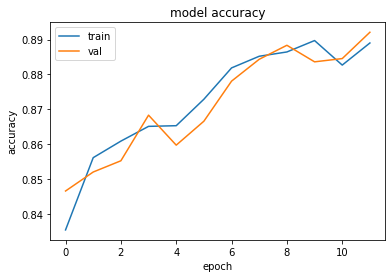

In [ ]:
# print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

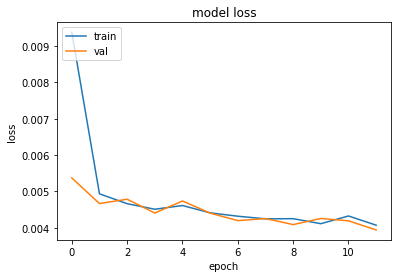

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




**Auto-Encoder  with *LReLu* 2nd Approach**



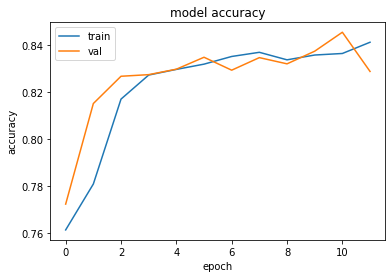

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

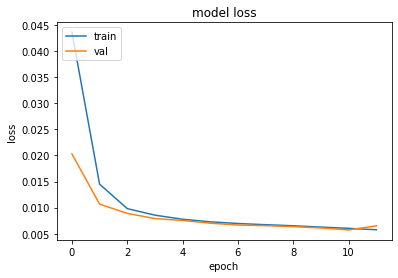

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Autoencoder using selu activation 3d Approach**

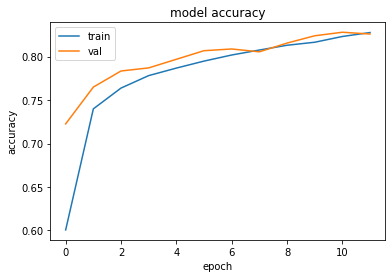

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

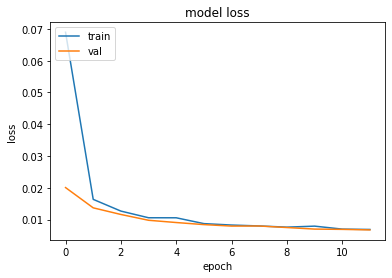

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

 **AutoEncoder  using BatchNorm 4th Approach**


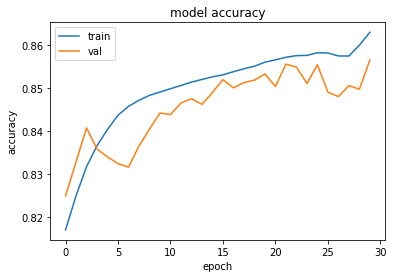

In [ ]:
# print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

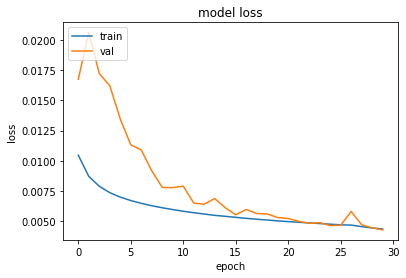

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Comments on Model A:**
 From all the above expirements decide to use the *model A*'s architecture of single conv2d layers with decreasing size of filter 32,16,8 with activation function ReLu and with additional BatchNormalization layers between each conv and activation layer. The best trade off for batch size was 128 and 12 epochs. Important notice is that the input data are loaded in batches to memory using python generators, inorder to deal with memory restrictions.

# **Model B**

*Using double and trible conv layer increasing filter size from 32 (x2 layers),64 (x3layers),128 (x3 layers). Total params to be trained ~800K (encoder+deconder). Encoder -> conv2d(32) x2, conv2d(64)x3 and conv2d(128)x3 while the decoder is the inversed layer orderof the encoder. BatchNorm is used after its conv layer while activation layer is applied every two  conv2d layers.*



```
        layers.Conv2D(filters=32, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Conv2D(filters=32, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.MaxPooling2D(pool_size=2,strides=2),
        
        layers.Conv2D(filters=64, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.MaxPooling2D(pool_size=2,strides=2),

        layers.Conv2D(filters=64, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Conv2D(filters=128, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.MaxPooling2D(pool_size=2,strides=2),

        layers.Conv2D(filters=128, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Conv2D(filters=128, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Activation('relu'),
```



In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

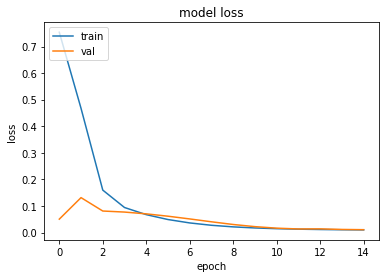

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Comments on Model B:**

By increasing the total number of the autoencoder's parameters to train up to ~800k and the number of epochs to 30, the model seems to overfitting *(see the gab between train accuracy and validation accuracy)* so the next approach of a model would be to reduce the parameters of the model and keeping the epochs size around 15, which seems the optimal choice.

# Model C

Encoder 



```
        layers.Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'), # Learn 2D Representations
        layers.MaxPooling2D(pool_size=2,strides=2),
        
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'), # Learn 2D Representation        
        layers.MaxPooling2D(pool_size=2,strides=2),

        
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'), # Learn 2D Representations       
        layers.MaxPooling2D(pool_size=2,strides=2),```



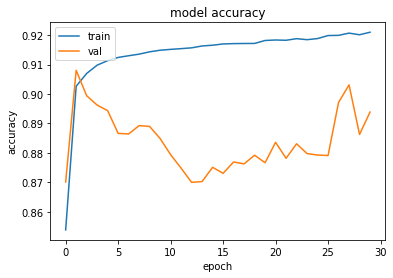

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

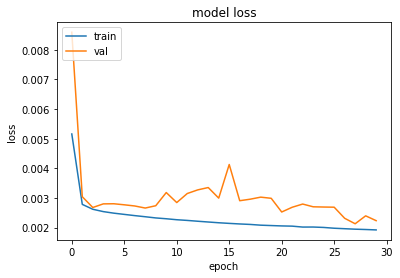

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Comments on Model C :**

After trying to reduce the size of the model and make it simplier I found out that model is overfitting again, so in the next approach I will reduce the batch size and keep the number of epochs around 15-20, and use BatchNorm between conv2d and activation layer while using a model with increasing filter size of conv2d. In a nutshell, I combine the best approaches in matters of model size and complexity between the models A,B,C.

# Model **D**


Encoder
```
        layers.Conv2D(filters=32, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.MaxPooling2D(pool_size=2,strides=2),
        
        layers.Conv2D(filters=64, kernel_size=3, padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
        
        layers.Activation('relu'),
        
        layers.MaxPooling2D(pool_size=2,strides=2),

        
        layers.Conv2D(filters=64, kernel_size=3,  padding='same'), # Learn 2D Representations
        layers.BatchNormalization(),
       
        layers.Activation('relu'),
        
        layers.MaxPooling2D(pool_size=2,strides=2),
```



**Plot of training process**

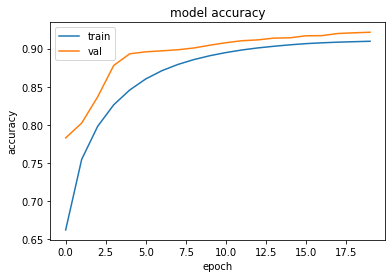

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

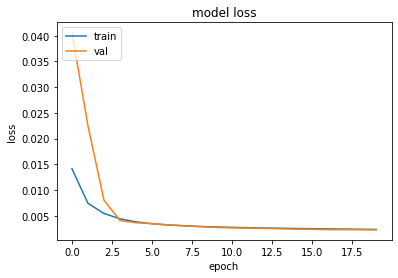

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
stacked_autoencoder.save('cnn3_autoenc.h5')
stacked_autoencoder.save_weights('cnn3_autoenc_weights.h5')
json_arch = stacked_autoencoder.to_json()
jsonFile = open("model_arch_autoen.json", "w")
jsonFile.write(json_arch)
jsonFile.close()

**Comments on Model D:**

Model seems to perform well for a batch size of 64 using BatchNormalization between conv2d layer and activation layer. A small network is used with 3 conv2d layers with filter sizes 32,64,64 and a kernel of size 3x3. This is the model in which I get the part of encoder and add new dense layers at the top in order to classify images into real or fake.

# **Part B Use Encoder to classify**

In [ ]:
!ls -la


total 20
drwxr-xr-x 1 root root 4096 Jul 13 15:25 .
drwxr-xr-x 1 root root 4096 Jul 13 15:24 ..
drwxr-xr-x 4 root root 4096 Jul  1 13:41 .config
drwx------ 5 root root 4096 Jul 13 15:25 drive
drwxr-xr-x 1 root root 4096 Jul  1 13:42 sample_data


In [ ]:

my_model = model_from_json(open('model_arch_autoen.json').read())
print('Original AutoEncoder Model summary as two Sequentials \n')
my_model.summary()
my_model.load_weights('cnn3_autoenc_weights.h5') #load weights

# Create model from using encoder only 
encoder =  Sequential([
                       layers.InputLayer([256,256,3]),
                       my_model.get_layer('sequential_13')
])

print('\n Create again encoder model with the same weights as trained \n')
encoder.summary()
encoder_outshape = encoder.layers[-1].output_shape

Original AutoEncoder Model summary as two Sequentials 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 32, 32, 64)        56960     
_________________________________________________________________
sequential_14 (Sequential)   (None, 256, 256, 3)       93839     
Total params: 150,799
Trainable params: 93,513
Non-trainable params: 57,286
_________________________________________________________________

 Create again encoder model with the same weights as trained 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 32, 32, 64)        56960     
Total params: 56,960
Trainable params: 0
Non-trainable params: 56,960
_________________________________________________________________


# **Add Dense layers to the encoder**



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        51232     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 80)                655440    
_________________________________________________________________
dense_10 (Dense)             (None, 30)               

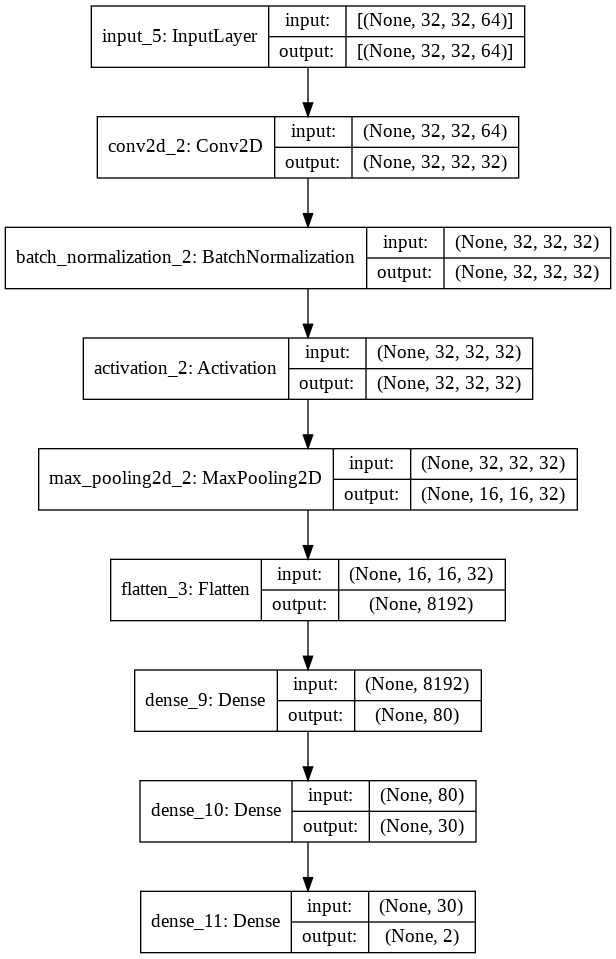

In [ ]:
"""#**Fully Connected Block** {Classifier}"""


num_class =2 # real or fake


fc_block = Sequential([
                                    layers.InputLayer(encoder_outshape[1:]),
                                    layers.Conv2D(filters=32, kernel_size=5,  padding='same'), # Learn 2D Representations
                                    layers.BatchNormalization(),        
                                    layers.Activation('relu'),
        
                                    layers.MaxPooling2D((2,2)),
                                    layers.Flatten(),
                                    layers.Dense(80,activation='relu'),
                                    #layers.Dropout(0.5),
                                    # layers.Dense(256,activation='relu'),
                                    # layers.Dropout(0.2),
                                    layers.Dense(30,activation='relu'),
                                    # layers.Dropout(0.2),
                                    # keras.layers.Dense(64,activation='relu'),
                                    layers.Dense(num_class,activation="softmax"),
])

fc_block.summary()
utils.plot_model(fc_block, show_shapes=True)

# **Reading image data and creating labels**

*Data Generators*

In [ ]:
def image_gen(imgs_paths):
    # Iterate over all the image paths
    for image_file in imgs_paths: 
              
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(image_file) / 255.
                      
        # Yield the image mask pair
        yield img

# pass as input a lsit with images paths a list with integer numbers per class, and a batch size
# imgs_paths must have the same length with labels
def image_batch_generator(imgs_paths, labels, batchsize=32):
    while True:
        ig = image_gen(imgs_paths)
        batch_img, batch_labels = [],[]
        
        for img, label in zip(ig,labels):
            # Add the image and mask to the batch
            batch_img.append(img)
            batch_labels.append(label)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize :
                yield np.stack(batch_img, axis=0),np.stack(utils.to_categorical(batch_labels), axis=0)
                batch_img,batch_labels = [],[]
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0 :
            yield np.stack(batch_img, axis=0), np.stack(utils.to_categorical(batch_labels), axis=0)
            batch_img, batch_labels= [],[]

*Reading paths and labels and split data*

In [ ]:

# load path of real images data
folderReal = 'dataset2/real'
train_img_paths = [os.path.join(folderReal,filename)for filename in os.listdir(folderReal)]
labels = [1]*len(train_img_paths) # 1 is for Real image label 
print(train_img_paths[:10])
print(labels)
print(len(labels))

# load paths of fake ones
folderFake = 'dataset2/fake'
train_img_paths_fake = [os.path.join(folderFake,filename)for filename in os.listdir(folderFake)]

train_img_paths.extend(train_img_paths_fake) # add fake images paths
labels.extend([0]*len(train_img_paths_fake)) # 0 zero is for Fake image label
print('Fake images number',len(train_img_paths_fake))

print('\n |> Whole images fakes and real ones, ', train_img_paths,'\n ',labels)
print('\n |> Size of all images fake and real img_paths_size =',len(train_img_paths),'Labels size =',len(labels))

# ohe_labels =utils.to_categorical(labels) # label 1 is converted to [0. 1.]--Real and 0 is converted to [1. 0.] --Fake
# print('\n Ohe Labels \n',type(ohe_labels),ohe_labels)

# img=imread(train_img_paths[0])
# print(img.shape)
# # Split the data into a train and validation set
train_img_paths, val_img_paths,train_labels,val_labels = train_test_split(train_img_paths,labels, test_size=0.2,shuffle=True,stratify=labels)

# Check if set are splitted correctly
print('\n Train set Labels ',train_labels)
print('\n Size of training data ', len(train_labels),len(train_img_paths))
print('\n Training Images paths ',train_img_paths)

print('\n Number of Real Images ',len([x for x in train_img_paths if 'real' in x]))
print('\n Number of Real Images counting labels ',len([x for x in train_labels if x==1]))

# Split valid set into half and create valid and test set
test_img_paths, val_img_paths,test_labels,val_labels = train_test_split(val_img_paths,val_labels, test_size=0.5,shuffle=True,stratify=val_labels)
print('\n *Size of each test and validation sets 1% of the total(20k)',len(test_img_paths),len(val_img_paths))


['dataset2/real/45114.jpg', 'dataset2/real/17690.jpg', 'dataset2/real/57287.jpg', 'dataset2/real/14277.jpg', 'dataset2/real/20354.jpg', 'dataset2/real/45389.jpg', 'dataset2/real/67781.jpg', 'dataset2/real/10136.jpg', 'dataset2/real/53186.jpg', 'dataset2/real/19278.jpg']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

*With the above run we can see that each dataset training,validation,test contains the same percentage of real and fake images. For example the train set is containing 16k which are 8k real and 8k fakes. This means that we splitted the dataset with correct way.*

# **Training for the final classifier**

In [ ]:
BATCHSIZE = 128
# Create the train and validation generators
traingen = image_batch_generator(train_img_paths,train_labels, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths,val_labels, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

encoder.trainable= False
stacked_classifier = Sequential([encoder, fc_block])
# stacked_classifier = Sequential([layers.InputLayer([256,256,3]),
#                                  layers.Flatten(),
#                                  layers.Dense(64,activation='relu'),
#                                  layers.Dense(128,activation='relu'),
#                                  layers.Dense(num_class,activation='softmax')])

opt = optimizers.Adam(learning_rate=0.01)
# Compile the stacked model and train with adam
stacked_classifier.compile(loss="binary_crossentropy",
                   optimizer=opt,metrics=["accuracy"])
# Train the model
history_classifier = stacked_classifier.fit(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs=40, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=10 # Change this number based on memory restrictions
)

Epoch 1/40
125/125 [==============================] - 2680s 22s/step - loss: 0.7286 - accuracy: 0.6807 - val_loss: 1.6051 - val_accuracy: 0.5010
Epoch 2/40
125/125 [==============================] - 70s 563ms/step - loss: 0.4615 - accuracy: 0.7806 - val_loss: 0.9352 - val_accuracy: 0.5935
Epoch 3/40
125/125 [==============================] - 70s 561ms/step - loss: 0.3522 - accuracy: 0.8455 - val_loss: 0.5301 - val_accuracy: 0.7680
Epoch 4/40
125/125 [==============================] - 70s 561ms/step - loss: 0.2803 - accuracy: 0.8824 - val_loss: 0.4246 - val_accuracy: 0.8190
Epoch 5/40
125/125 [==============================] - 70s 563ms/step - loss: 0.2224 - accuracy: 0.9107 - val_loss: 0.3562 - val_accuracy: 0.8585
Epoch 6/40
125/125 [==============================] - 70s 565ms/step - loss: 0.2367 - accuracy: 0.9013 - val_loss: 0.3105 - val_accuracy: 0.8860
Epoch 7/40
125/125 [==============================] - 70s 567ms/step - loss: 0.1517 - accuracy: 0.9417 - val_loss: 0.3516 - val_ac

# **Training Results -Classifier**

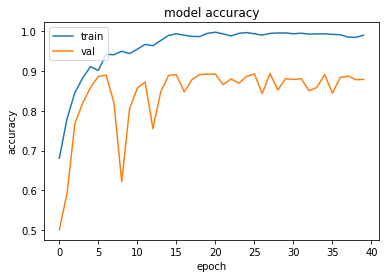

In [ ]:

plt.plot(history_classifier.history['accuracy'])
plt.plot(history_classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


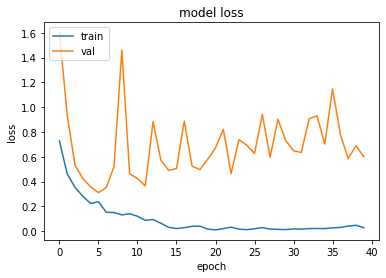

In [ ]:
"""Plot Loss Graph of Auto-encoder"""
plt.plot(history_classifier.history['loss'])
plt.plot(history_classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Test Evaluate**

In [ ]:
# Create the test generators

testgen = image_batch_generator(test_img_paths,test_labels, batchsize=BATCHSIZE)

from sklearn.metrics import classification_report

y_pred = stacked_classifier.predict(testgen,   verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))


  10403/Unknown - 5549s 533ms/step